# Notebook example

This notebook shows an example of how to use BowshockPy package. Although BowshockPy can be easily run from a input file, BowshockPy classes provide a more flexible usage. As an example, this notebook shows how to obtain a synthetic spectral cube, moments and position-velocity diagrams of the CO(3-2) emission of two bowshock models.

We will need to import four classes from BowshockPy, and go through four different steps:
1. Creation of the bowshock model with **BowshockModel**: This class contains all the equations of a analytic momentum-conserving bowshock model. It can be instantiate with he model parameters as input, and you can visualize the model with _get_modelplot_ method.
2. Obtain the projection of the bowshock model with **ObsModel**: This class contains all the equations needed to project the bowshock model. You will need to give some parameters that depends on the observer (as the inclination angle and the systemic velocity) in order to instantiate the class. The method _get_modelplot_ allows to get a visualization of the projected morphology and kinematics of the bowshock model.
3. Computation of the masses of the spectral cube with **BowshockCube**: This class computes the masses in each pixel and velocity channels of the spectral cube. It also contains the the plot_channel_ and _plot_channels_ methods for the visualization of the channels maps.
4. Radiative transfer with **CubeProcessing**: This class allows to perform the radiative transfer in order to obtain the intensities of the rotational transition of the CO molecule, and convolve with a gaussian beam in order to get an synthetic observation. Also, you can obtain the moments and position-velocity diagrams from its methods, and save the results in fits format.

For an detailed description of the functioning, instantiation input parameters, attributes, and methods of each class, see the [API reference](https://bowshockpy.readthedocs.io/en/latest/api/index.html)


In [1]:
import numpy as np

from astropy import units as u

import matplotlib.pyplot as plt

from bowshockpy import BowshockModel, ObsModel, BowshockCube, CubeProcessing
from bowshockpy import __version__

In [2]:
print(f"Using BowshockPy v{__version__}")

Using BowshockPy v0.2.6


In [3]:
from bowshockpy import radtrans as rt

from bowshockpy import radtrans_linearmol as rt_new


In [4]:
nu = 345 * u.GHz
J = 3
Tex = 100 * u.K
mu = 0.112 * u.Debye
dN = 6*10**(16) * u.cm**(-2)
dv = 1.5 * u.km/u.s

rt.tau_N( nu=nu, J=J, Tex=Tex, mu=mu, dNdv = dN/dv).to("")

<Quantity 0.66412175>

In [6]:
rt_new.tau_N(
    dNmol=dN,
    dv=dv,
    nu=nu,
    Tex=Tex,
    i=J,
    Ei=rt_new.EJ,
    gi=rt_new.gJ,
    mui=rt_new.muJ_Jm1,
    Ei_args=(rt_new.B0J(J, nu)),
    gi_args=(),
    mui_args=(mu),
).to("")



<Quantity 0.66412175>

## 1. Creation of the bowshocks through **BowshockModel** class

In this example, we aim to create synthetic observations of two consecutive bowshocks of the same jet. We first define the parameters of both bowshock model and instantiate the **BowshockModel** class

In [3]:
# Distance to the source in pc
distpc = 300

###
# Parameters for the bowshock 1
###

# name of the model
modelname1 =  f"Bowshock1"

# Characteristic lenght scale of the bowshock [km] 
L0_1 = (0.4 * distpc * u.au).to(u.km).value

# distance from the source to the internal working surface [km]
zj_1 = (4 * distpc * u.au).to(u.km).value 

# velocity of the internal working surface [km/s]
vj_1 = 100                                   

# velocity of the ambient [km/s]
va_1 = 5                                      

# velocity at which the material is ejected sideways [km/s]
v0_1 = 15                                    

# total mass of the bowshock shell [Msun]
mass_1 = 0.0002                              

# final radius of the bowhsock [km]
rbf_obs_1 = (0.7 * distpc * u.au).to(u.km).value

model1 = BowshockModel(
    L0=L0_1,
    zj=zj_1,
    vj=vj_1,
    va=va_1,
    v0=v0_1,
    mass=mass_1,
    rbf_obs=rbf_obs_1,
    distpc=distpc,
    )


###
# Parameters for the bowshock 2
###

modelname2 =  f"Bowshock2"
L0_2 = (0.33 * distpc * u.au).to(u.km).value
zj_2 = (3 * distpc * u.au).to(u.km).value 
vj_2 = 95
va_2 = 5
v0_2 = 10
mass_2 = 0.00015
rbf_obs_2 = (0.55 * distpc * u.au).to(u.km).value

model2 = BowshockModel(
    L0=L0_2,
    zj=zj_2,
    vj=vj_2,
    va=va_2,
    v0=v0_2,
    mass=mass_2,
    rbf_obs=rbf_obs_2,
    distpc=distpc,
    )

We have access to some useful parameters from the instantiation of **BowshockModel**

In [4]:
print(
f"""
Bowshock 1:
Density of the ambient: {model1.rhoa_gcm3:.2e} g/cm^3
Mass rate of material ejected sideways from the internal working surface: {model1.mp0_solmassyr:.2e} Msun/yr
Mass rate of material incorporated into the bowshock surface: {model1.mpamb_f_solmassyr:.2e} Msun/yr

Bowshock 2:
Density of the ambient: {model2.rhoa_gcm3:.2e} g/cm^3
Mass rate of material ejected sideways from the internal working surface: {model2.mp0_solmassyr:.2e} Msun/yr
Mass rate of material incorporated into the bowshock surface: {model2.mpamb_f_solmassyr:.2e} Msun/yr
"""
)


Bowshock 1:
Density of the ambient: 3.92e-19 g/cm^3
Mass rate of material ejected sideways from the internal working surface: 1.26e-06 Msun/yr
Mass rate of material incorporated into the bowshock surface: 1.83e-06 Msun/yr

Bowshock 2:
Density of the ambient: 3.63e-19 g/cm^3
Mass rate of material ejected sideways from the internal working surface: 1.07e-06 Msun/yr
Mass rate of material incorporated into the bowshock surface: 9.93e-07 Msun/yr



We can obtain a graphical representation of the two models with _get_modelplot_ method

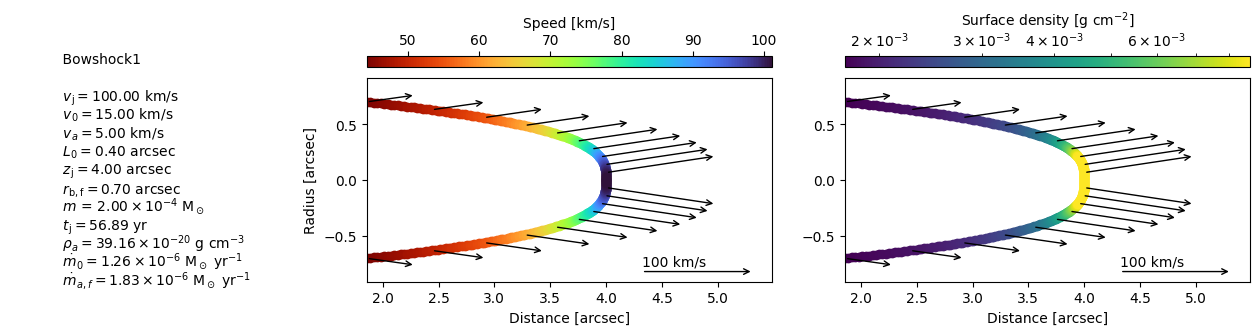

In [5]:
model_plot1 = model1.get_modelplot(
    modelname=modelname1,
#    v_arrow_ref=100,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
model_plot1.plot()

# Optionally, you can save the figure with savefig method
model_plot1.savefig()

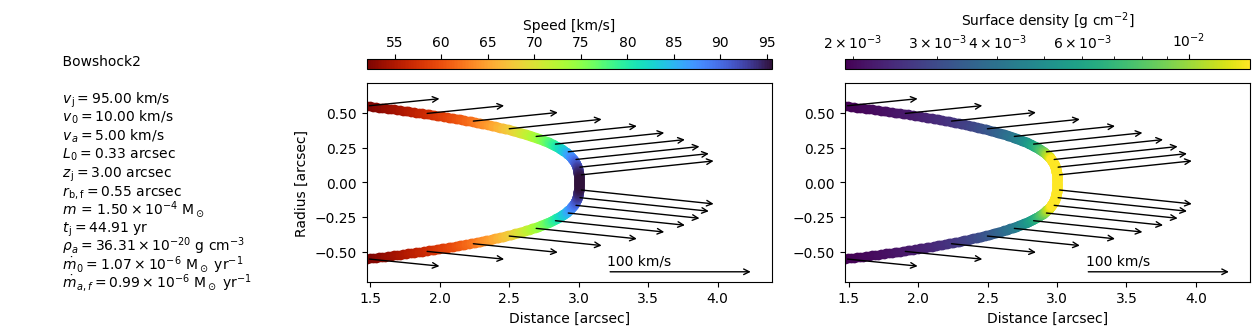

In [6]:
model_plot2 = model2.get_modelplot(
    modelname=modelname2,
#    v_arrow_ref=100,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
model_plot2.plot()

# For comparison, you can put the same x-axis limits as for the first model by:
# model_plot2.axs[0].set_xlim([*model_plot1.axs[0].get_xlim()])
# model_plot2.axs[1].set_xlim([*model_plot1.axs[1].get_xlim()])

model_plot2.savefig()

## 2. Projection of the bowshocks with **ObsModel** class

Once we have created the two bowshocks, we want to projected the morphology onto the plane-of-sky and the velocity field along the line-of-sight velocity. We can do this using ObsModel class. In this example, we will use the same inclination for both bowshocks

In [7]:
# inclination angle of the bowshock axis with the line-of-sight. Use
# innclination angles > 90 for redshifted jets, <90 for blueshifted jets
# [degrees]
i_deg = 110

# Position angle of the bowshock [degrees]
pa_deg = -10

# Systemic velocity of the source
vsys = 5

model_obs1 = ObsModel(
    model1, # instantiation of BowshockModelodelodel
    i_deg=i_deg, 
    pa_deg=pa_deg,
    vsys=vsys, 
    )

model_obs2 = ObsModel(
    model2,
    i_deg=i_deg, 
    pa_deg=pa_deg,
    vsys=vsys, 
    )

We can obtain a visualization of the projected morphology and kinematics of the bowshock model using the _get_modelplot_ method 

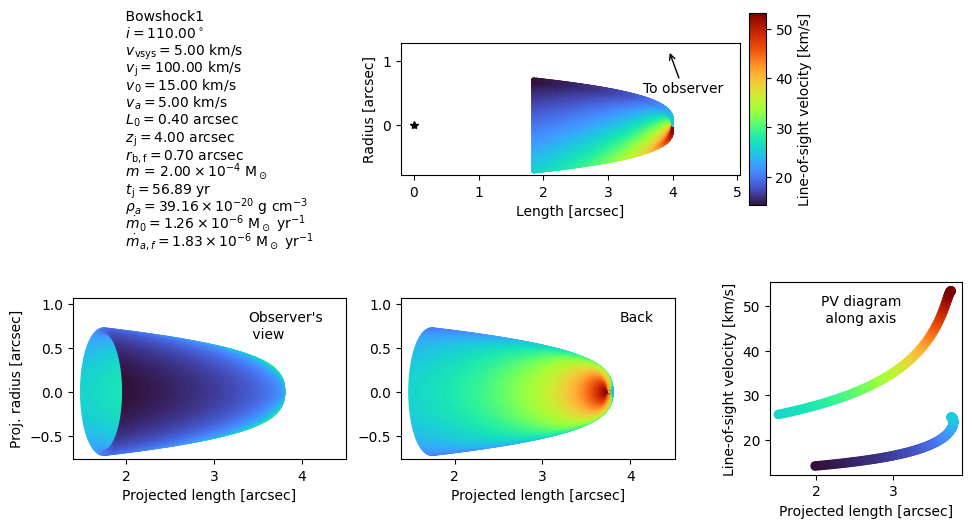

In [8]:
model_obs_plot = model_obs1.get_obsmodelplot(
    modelname=modelname1,
    figsize=(12, 6),
    maxpointsize=10,
    # minpointsize=0.1,
    )
model_obs_plot.plot()
# Make your custom modifications on the plot here
# model_obs_plot.axs[0].set_xlim([0, 5])
model_obs_plot.savefig(figname=f"models/{modelname1}_modelproj.jpg", dpi=300)

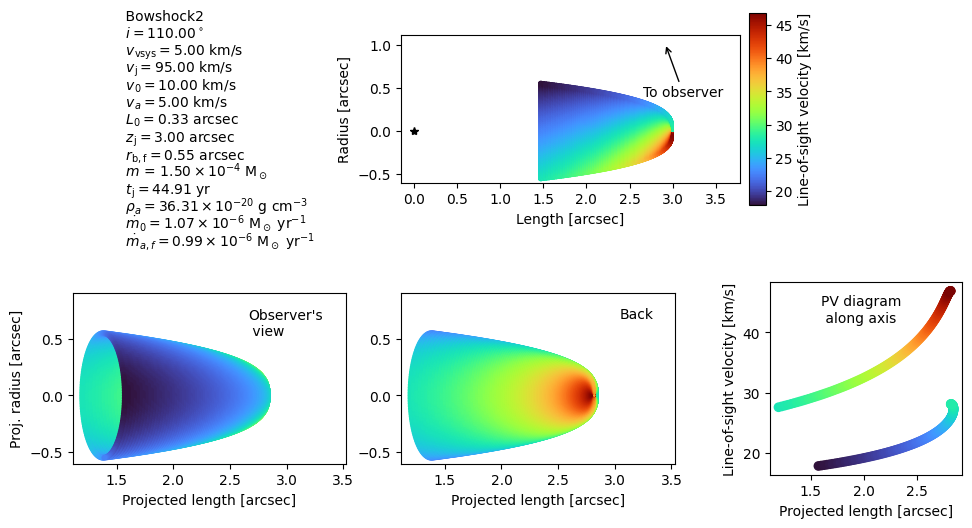

In [9]:
model_obs_plot2 = model_obs2.get_obsmodelplot(
    modelname=modelname2,
    figsize=(12, 6),
    maxpointsize=10,
    # minpointsize=0.1,
    )
model_obs_plot2.plot()
# Make your custom modifications on the plot here
# model_obs_plot.axs[0].set_xlim([0, 5])
model_obs_plot2.savefig(figname=f"models/{modelname2}_modelproj.jpg", dpi=300)

## 3. Computation of the masses in the spectral cube with **BowshockCube**

Let's now compute the masses in each pixel and each channel of the spectral cube for each of the bowshocks. You can use the position velocity diagrams of the last two figures in order to choose an appropiate range of velocities covered by the spectral cubes (vhc0 and vchf) and the physical size (xpmax) of the channel maps. Be aware that, due to the thermal+turbulent line of sight velocity dispersion (controled by vt parameter), the velocity range covered by the spectral cube should be higher than the one displayed in the position-velocity diagrams shown in the last figures. Otherwise, bowshock model will not be fully covered (velocity disperions are not included in the last two figures)

In [10]:
# Number of model points along the z-axis direction
nzs = 1000

# Number of azimuthal angle phi for each z-axis point to calculate the bowshock solution
nphis = 500

# Number of spectral channel maps
nc = 50

# Central velocity of the first channel map [km/s]
vch0 = 10

# Central velocity of the last channel map [km/s]
vchf = 60

# Number of pixels in the x and y axes
nxs, nys = (150, 150)

# Physical size of the channel maps along the x axis [arcsec]
xpmax = 5

# Thermal+turbulent line-of-sight velocity dispersion [km/s] 
# If thermal+turbulent line-of-sight velocity dispersion is smaller than the
# instrumental spectral resolution, vt should be the spectral resolution. It
# can be also set to a integer times the channel width, in this case it would be
# a string [e.g., "2xchannel"]
vt = "2xchannel"

# Set to true in order to perform a Cloud in Cell interpolation. If False,
# nearest neighbour point sampling will be performed [True/False]
cic = True

# Neighbour channel maps around a given channel map with vch will stop being
# populated when their difference in velocity with respect to vch is higher than
# this factor times vt. The lower the factor, the quicker will be the code, but
# the total mass will be underestimated. If vt is not None, compare the total
# mass of the output cube with the 'mass' parameter that the user has defined
tolfactor_vt = 3

# Reference pixel [[int, int] or None]
# Pixel coordinates (zero-based) of the source, i.e., the origin from which the
# distances are measured. The first index is the R.A. axis, the second is the
# Dec. axis.
refpix = [75, 15]

# Verbose messages about the computation? [True/False]
verbose = True

model_cube1 = BowshockCube(
    model_obs1,
    nphis=nphis,
    nzs=nzs,
    nc=nc,
    vch0=vch0, 
    vchf=vchf,
    xpmax=xpmax,    
    nxs=nxs,
    nys=nys, 
    refpix=refpix, 
    cic=cic,
    vt=vt,
    tolfactor_vt=tolfactor_vt,
    verbose=verbose,
    )
model_cube1.makecube()


Computing masses in the spectral cube...
  0──────────────────────────────────────────────────)100.0% | 95/97s
Checking total mass consistency...

Mass consistency test passed: The input total mass of the bowshock model
coincides with the total mass of the cube.



We set the same parameters for the second bowshock, so we can later combine both models using **CubeProcessing** class

In [11]:
model_cube2 = BowshockCube(
    model_obs2,
    nphis=nphis,
    nzs=nzs,
    nc=nc,
    vch0=vch0, 
    vchf=vchf,
    xpmax=xpmax,    
    nxs=nxs,
    nys=nys, 
    refpix=refpix, 
    cic=cic,
    vt=vt,
    tolfactor_vt=tolfactor_vt,
    verbose=verbose,
    )
model_cube2.makecube()


Computing masses in the spectral cube...
  0──────────────────────────────────────────────────)100.0% | 76/88s
Checking total mass consistency...

Mass consistency test passed: The input total mass of the bowshock model
coincides with the total mass of the cube.



You can inspect individual channel maps with *_plot_channel_* method

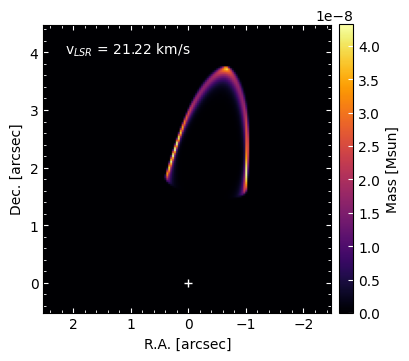

In [12]:
# Bowshock 1
model_cube1.plot_channel(chan=11, savefig=f"models/{modelname1}_channel_11.pdf")

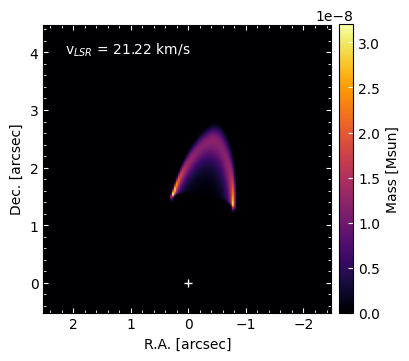

In [13]:
# Bowshock 2
model_cube2.plot_channel(chan=11, savefig=f"models/{modelname2}_channel_11.pdf")

You can use the _plot_channels_ method in order to visualize several channel maps

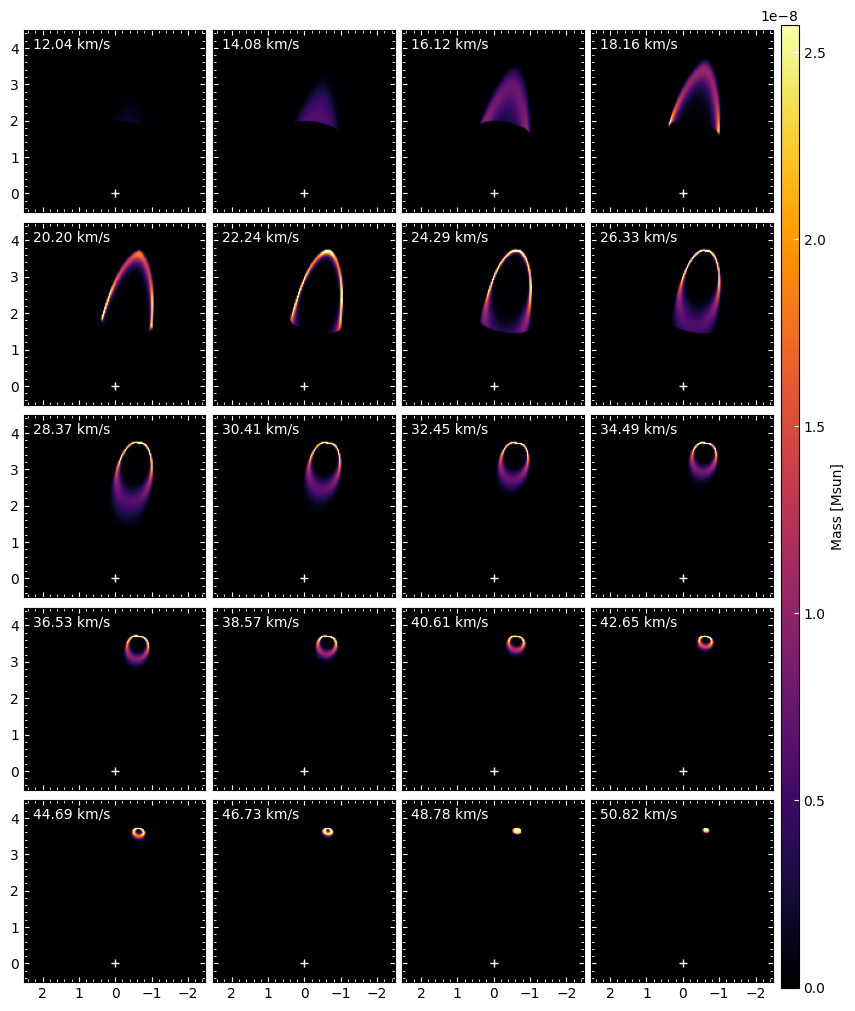

In [14]:
# Bowshock 1
model_cube1.plot_channels(
    nrow=5, ncol=4, 
    vmax=np.percentile(model_cube1.cube, 99.9),
    savefig=f"models/{modelname1}_channel_plots.pdf",
    )

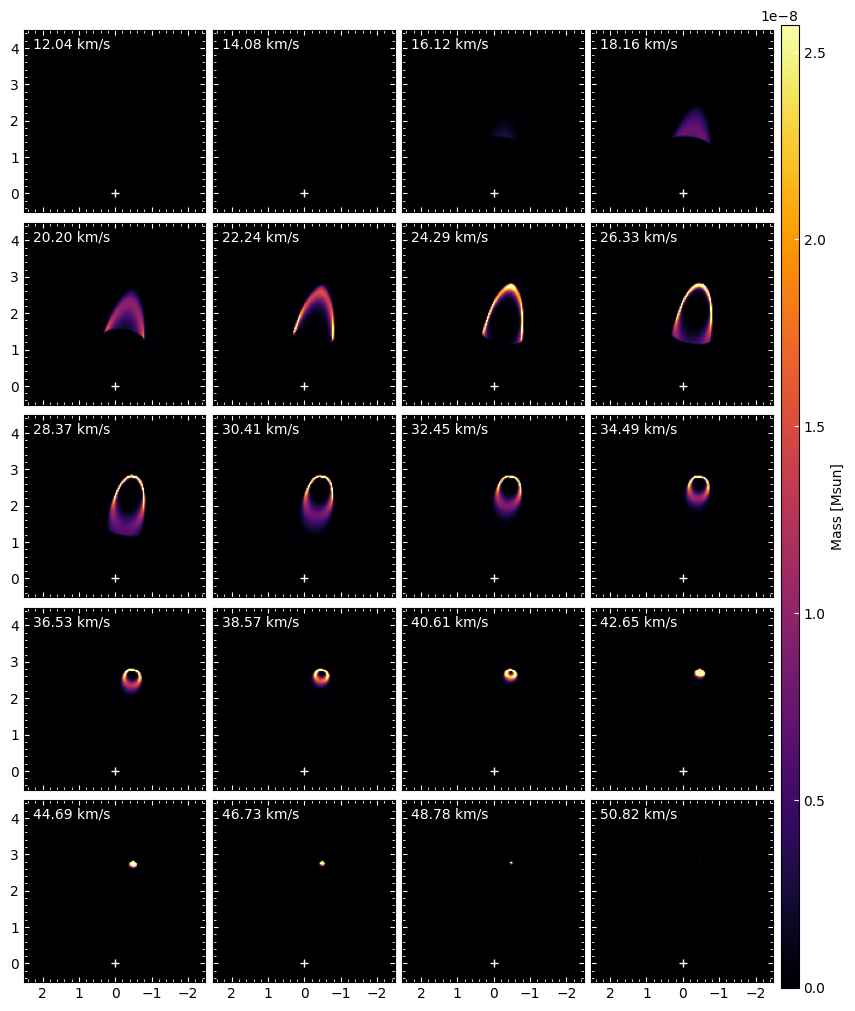

In [15]:
# Bowshock 2
model_cube2.plot_channels(
    nrow=5, ncol=4, 
    vmax=np.percentile(model_cube1.cube, 99.9),
    savefig=f"models/{modelname2}_channel_plots.pdf",
    )

## 4. Radiative transfer and moments and PV diagram with **CubeProcessing** class

We will use now **CubeProcessing** class to combine both cubes and perform the radiative transfer in order to obtain the intensities of the CO(3-2) transition. Also, would be able to obtain the moments and position-velocity diagrams. All the cubes and images can be save fits format and be open for further inspection with casaviewer or ds9.

In [ ]:
# Source coordinates [deg, deg] 
ra_source_deg, dec_source_deg = 84.095, -6.7675

# Upper level of the CO rotational transition
J = 3

# Excitation temperature [K]
Tex = 100

# Background temperature [K]
Tbg = 2.7

# Mean molecular mass per H molecule
meanmolmass = 2.8

# CO abundance
abund = 8.5 * 10**(-5)

# Beam size [arcsec]
bmaj, bmin = (0.2, 0.15)

# Beam position angle [degrees]
pabeam = +30

# Spectral cubes in offset or sky coordinates? ["offset" or "sky"]
coordcube = "offset"

# Angle to rotate the image [degrees]
parot = 0

# Standard deviation of the noise of the map, before convolution. Set
# to None if maxcube2noise is used [Jy/beam]
sigma_beforeconv = 0.05

# Standard deviation of the noise of the map, before convolution, relative to
# the maximum pixel in the cube. The actual noise will be computed after
# convolving. This parameter would not be used if sigma_beforeconve is not
# None.
maxcube2noise = 0.07

In [ ]:
cubes_proc = CubeProcessing(
    [model_cube1, model_cube2], # we want to combine both models
    modelname="bowshocks",
    J=J,
    abund=abund,
    meanmolmass=meanmolmass,
    Tex=Tex * u.K,
    Tbg=Tbg * u.K,
    coordcube=coordcube,
    ra_source_deg=ra_source_deg,
    dec_source_deg = dec_source_deg,
    bmin=bmin,
    bmaj=bmaj,
    pabeam=pabeam,
    papv=model_cube1.pa_deg,
    parot=0,
    sigma_beforeconv=sigma_beforeconv,
    maxcube2noise=maxcube2noise,
)

Let's check that the cubes with the masses of each bowshock have been combined. We can visualize the masses with _plot_channel_ method. The input "m", indicates you are interested in plotting the masses, which is the only cubes computed so far

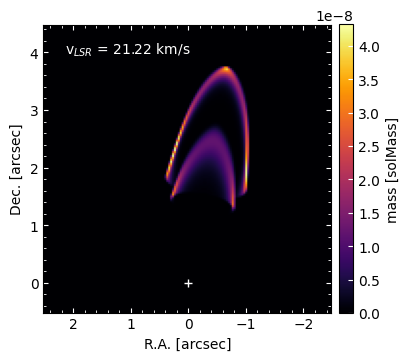

In [18]:
cubes_proc.plot_channel("m", chan=11,)

### 4.1 Computation of the intensities

In this example, we will go through the steps to compute the intensities of the CO(3-2) transition. First, lets compute the column densities.

In [19]:
cubes_proc.calc_Ntot()


Computing column densities...
column densities has been calculated



We can inspect a particular channel with _plot_channel_ method

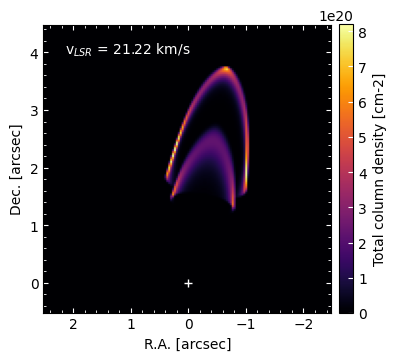

In [20]:
cubes_proc.plot_channel(ck="Ntot", chan=11)

Let's now compute the CO column densities

In [21]:
cubes_proc.calc_NCO()


Computing CO column densities...
CO column densities has been calculated



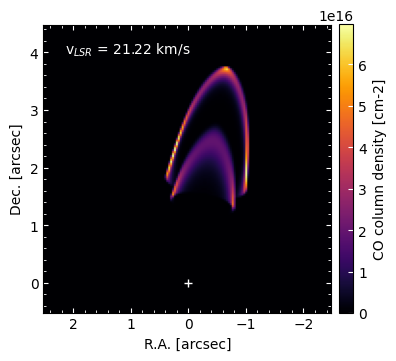

In [22]:
cubes_proc.plot_channel(ck="NCO", chan=11)

In [23]:
cubes_proc.calc_tau()


Computing opacities...
Opacities has been calculated



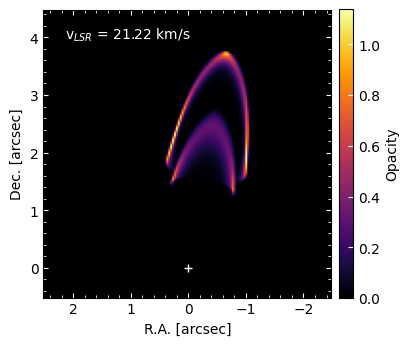

In [24]:
cubes_proc.plot_channel(ck="tau", chan=11)

In [25]:
cubes_proc.calc_I()


Computing intensities...
Intensities has been calculated



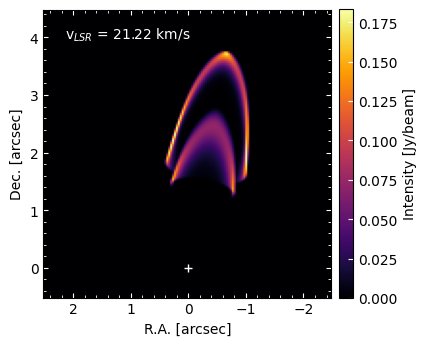

In [26]:
cubes_proc.plot_channel(ck="I", chan=11)

Note that although the units are Jy/beam, the model is not convolved yet. In order to perform the convolution with the beam, we should use the __convolve__ method

In [28]:
cubes_proc.convolve(ck="I")


Convolving I_c... 
  0──────────────────────────────────────────────────)100.0% | 0/0s

I_c has been convolved with a gaussian kernel with a size of [4.50, 6.00] pix and with a PA of 30.00deg



Let us inspect the convolved cube. Note that we should now use the label "I_c" to plot the cube of the convolved intesities 

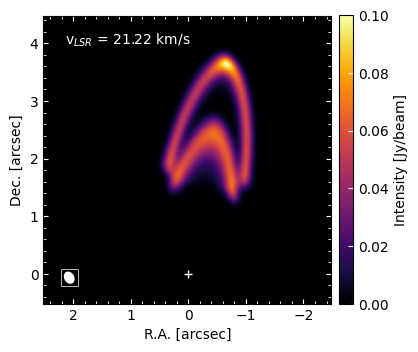

In [29]:
cubes_proc.plot_channel(ck="I_c", chan=11, add_beam=True)

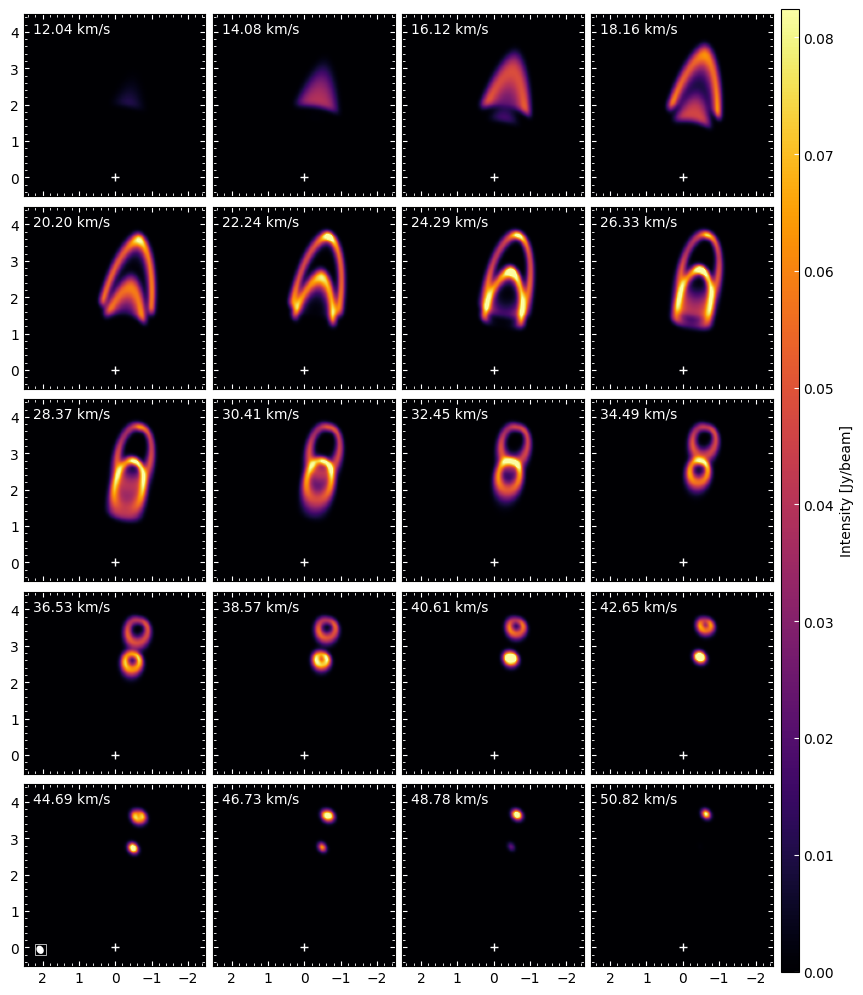

In [30]:
cubes_proc.plot_channels(
    ck="I_c",
    vmax=np.percentile(cubes_proc.cubes["I_c"], 99.9),
    nrow=5, ncol=4, 
    add_beam=True
    )

Additionally, you can simulate how your spectral cube would be seen with Gaussian noise by using _add_noise_ method. Lets add noise to the intensity cube and then convolve.

In [31]:
cubes_proc.add_noise(ck="I")
cubes_proc.convolve(ck="I_n")


Adding noise to I_n...
Noise added to I_n


Convolving I_nc... 
  0──────────────────────────────────────────────────)100.0% | 0/0s

I_nc has been convolved with a gaussian kernel with a size of [4.50, 6.00] pix and with a PA of 30.00deg


The rms of the convolved image is 0.0063488 Jy/beam



The label of the cube of the intensities with noise and convolved is "I_nc". Let's inspect it

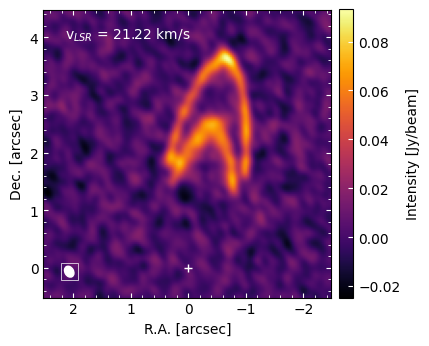

In [32]:
cubes_proc.plot_channel(ck="I_nc", chan=11, add_beam=True)

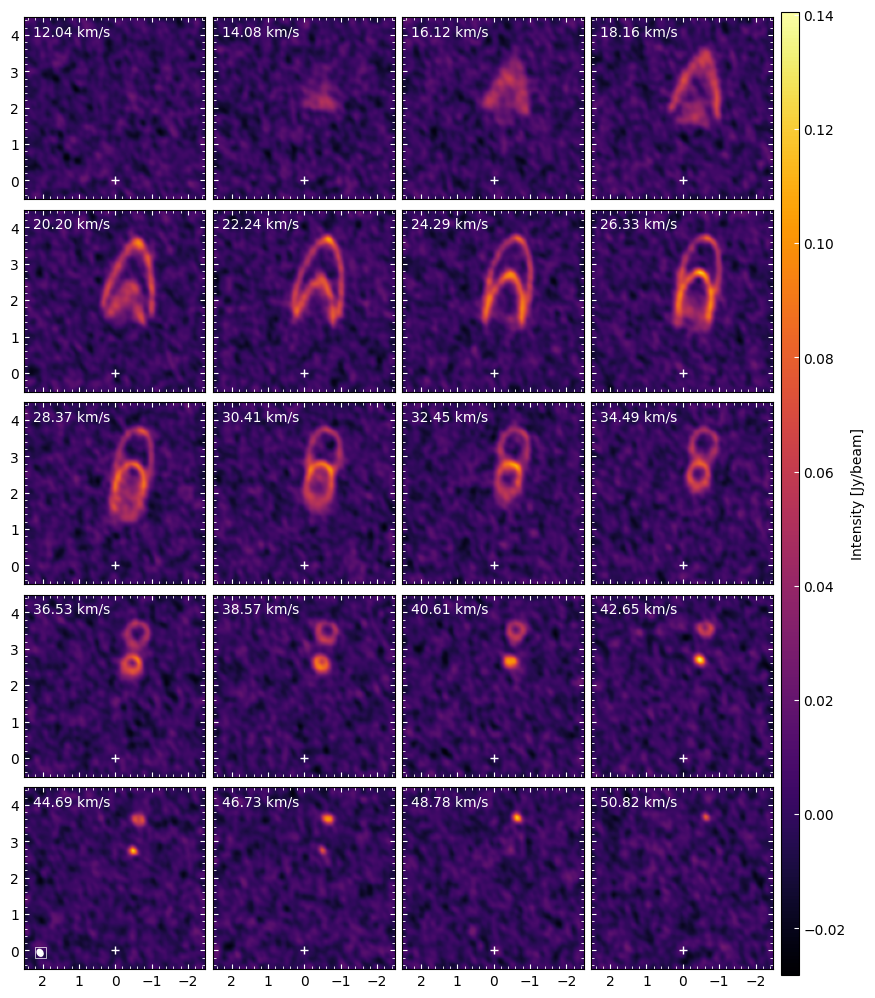

In [33]:
cubes_proc.plot_channels(
    ck="I_nc",
    nrow=5, ncol=4, 
    # vmin=-0.005,
    # vcenter=(0.07-0.005)/2,
    # vmax=0.07,
    add_beam=True,
    )

One can inspect the cubes computed so far and stored in cubes_proc:

In [34]:
cubes_proc.cubes.keys()

dict_keys(['m', 'NCO', 'tau', 'I', 'Ntot', 'I_c', 'I_n', 'I_nc'])

The next table summarize the meaning of the cube labels and the units 

| Quantity                         | Cube label           | Unit
| :--------------------------------|:-------------------:|:--------------:
| Mass                             | m                   | solar mass
| Intensity                        | I                   | Jy/beam
| Intensity optically thin approx. | Ithin               | Jy/beam
| Column density                   | Ntot                | cm-2
| CO column density                | NCO                 | cm-2
| Opacities                        | tau                 |


and the labels for the operations performed to the cubes 



| Method     | Cube label
|:-----------|:----------------:
| add_source | s
| rotate     | r
| add_noise  | n
| convolve   | c

**Note**: CubeProcessing can compute directly the intensities using calc_I, without the need to run previously calc_NCO and calc_tau methods. If calc_I is run before explicitely computing the CO column densities or the opacities, they will be computed internally and stored in _cubes_ attribute.

You can save any cube stored in the CubeProcessing instance with _savecube_ method. For example:

In [35]:
cubes_proc.savecube("I_nc")

models/bowshocks/fits/I_nc.fits saved


### 4.2 Position velocity diagram and moment images

Let's now compute the position velocity diagram and moment images for some spectral cubes

#### Position Velocity digram


Rotatng I_cR in order to compute the PV diagram...
I_cR has been rotated 80 deg to compute the PV diagram

models/bowshocks/fits/I_cR_pv.fits saved


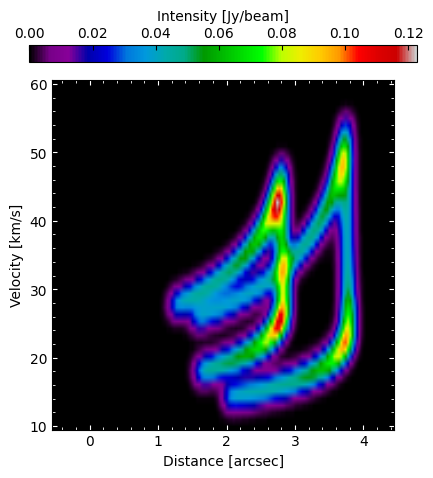

In [36]:
cubes_proc.plotpv(ck="I_c", halfwidth=2, savefits=True)


Rotatng I_ncR in order to compute the PV diagram...
I_ncR has been rotated 80 deg to compute the PV diagram

models/bowshocks/fits/I_ncR_pv.fits saved


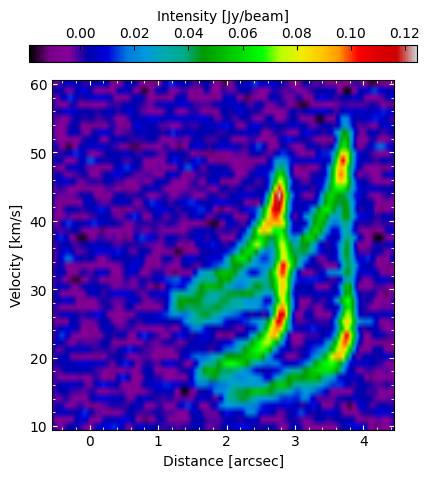

In [37]:
cubes_proc.plotpv("I_nc", halfwidth=2, savefits=True)

#### Moment 0

models/bowshocks/fits/I_nc_mom0.fits saved


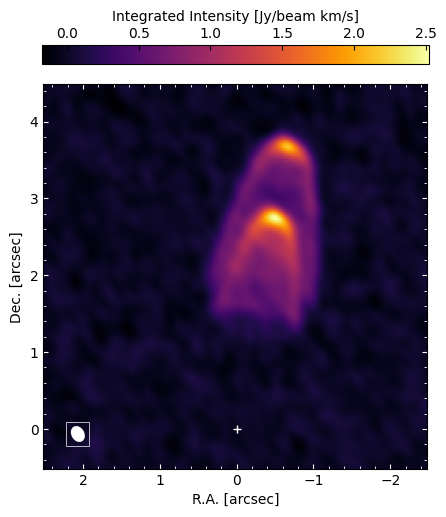

In [38]:
ck = "I_nc"
cubes_proc.plotmom0("I_nc", add_beam=True, savefits=True)


#### Maximum intensity

models/bowshocks/fits/I_nc_mom8.fits saved


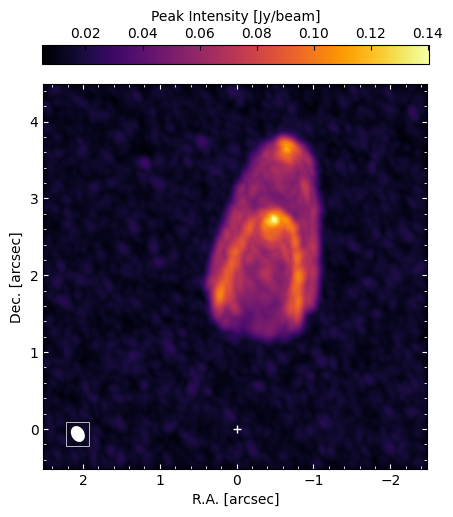

In [39]:
cubes_proc.plotmom8(ck="I_nc", add_beam=True, savefits=True)


#### Moment 1

models/bowshocks/fits/I_c_mom1.fits saved


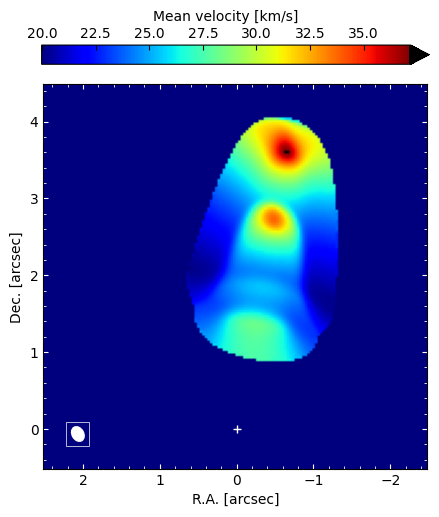

In [40]:
cubes_proc.plotmom1("I_c", add_beam=True, savefits=True)

models/bowshocks/fits/I_nc_mom1.fits saved


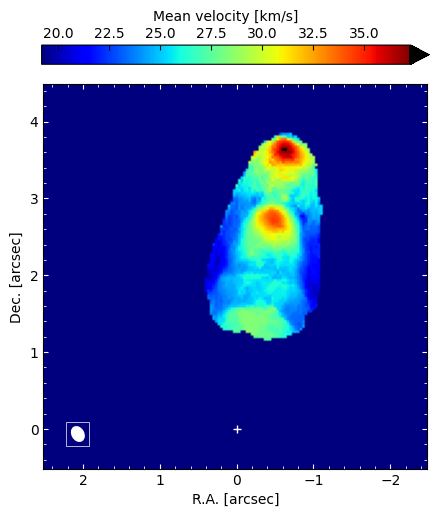

In [41]:
cubes_proc.plotmom1("I_nc", mom1clipping="5xsigma", add_beam=True, savefits=True)


#### Moment 2

models/bowshocks/fits/I_c_mom2.fits saved


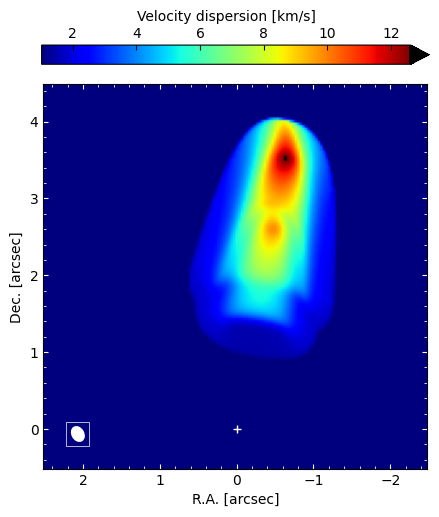

In [42]:
cubes_proc.plotmom2("I_c", add_beam=True, savefits=True)

models/bowshocks/fits/I_nc_mom2.fits saved


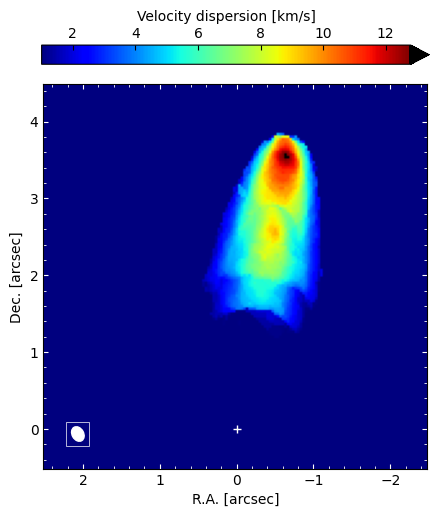

In [43]:
cubes_proc.plotmom2(ck="I_nc", mom2clipping="4xsigma", add_beam=True, savefits=True)


# Do all the computation at once

Alternatively, you can use the method _calc_ in order to calculate all the desired outputs. The input of _calc_ should be a dictionary, where the keys are the desired quantities and the values should be a list of strings indicating the operations to be performed. 

These are the available quantities of the spectral cubes:

- "mass": Total mass of molecular hydrogen in solar mass
- "Ntot_column_density": Total (H2 + heavier components) column density in cm-2.
- "CO_column_density": Column density of the CO in cm-2.
- "intensity": Intensity in Jy/beam.
- "intensity_opthin": Intensity in Jy/beam, using the optically thin approximation.
- "tau": Opacities.

The values of the dictionary are lists of strings indicating the operations to be performed over the cube. These are the available operations:

- "add_source": Add a source at the reference pixel, just for spatial reference purposes.
- "rotate": Rotate the whole spectral cube by an angle given by parot parameter.
- "add_noise": Add gaussian noise, defined by maxcube2noise parameter.
- "convolve": Convolve with a gaussian defined by the parameters bmaj, bmin, and pabeam.
- "moments_and_pv": Computes the moments 0, 1, and 2, the maximum intensity and the PV diagram.

The operations will be performed folowing the order of the strings in the list (from left to right). The list can be left empty if no operations are desired.


In [44]:
outcubes = {
    "intensity": ["add_noise", "convolve", "moments_and_pv"],
    "opacity": [],
    "CO_column_density": [],
    "mass": [],
    }

cubes_proc.calc(outcubes)
cubes_proc.savecubes(outcubes)


models/bowshocks/fits/I_nc.fits saved
models/bowshocks/fits/tau.fits saved
models/bowshocks/fits/NCO.fits saved
models/bowshocks/fits/m.fits saved


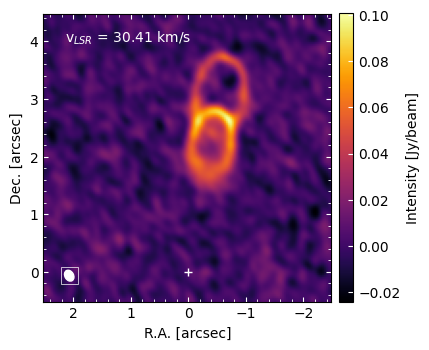

In [45]:
cubes_proc.plot_channel(ck="I_nc", chan=20, add_beam=True)



Computing moments and the PV-diagram along the jet axis



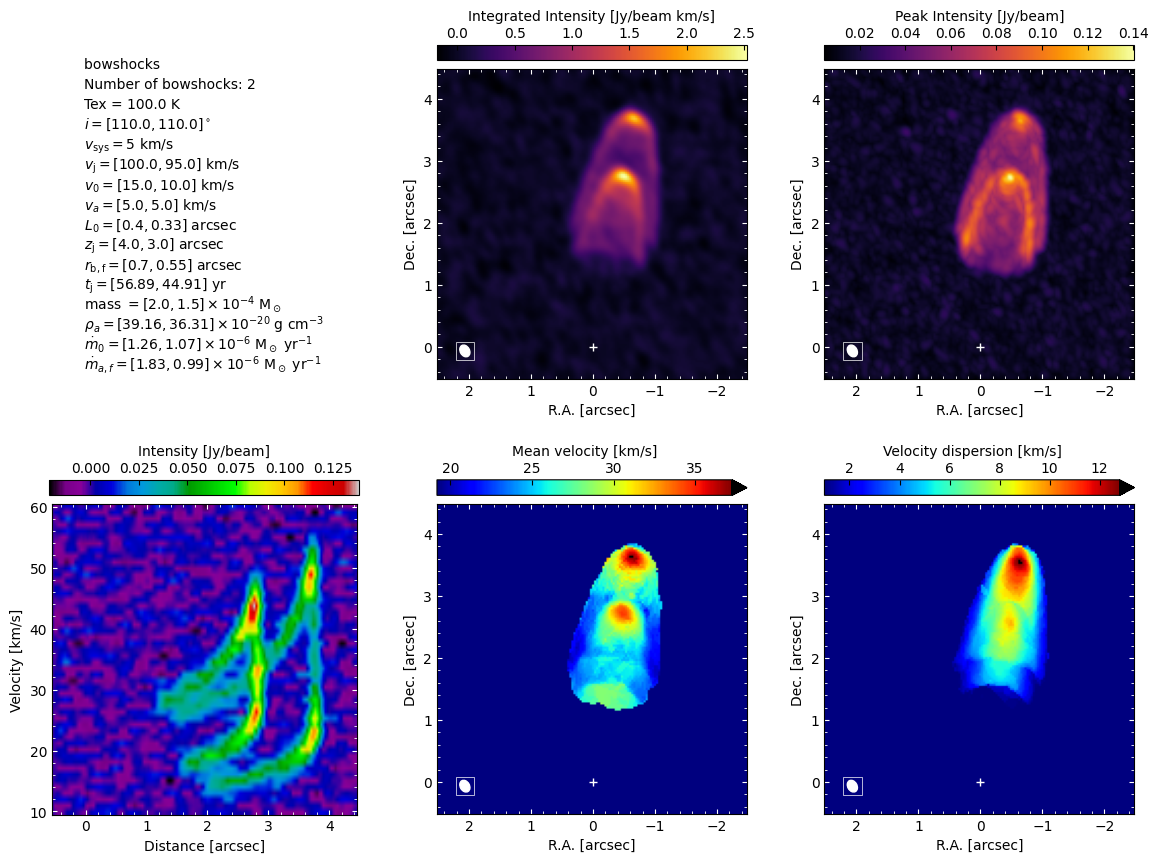

In [46]:
cubes_proc.momentsandpv_and_params("I_nc", mom1clipping="5xsigma", mom2clipping="4xsigma", add_beam=True)